<a href="https://colab.research.google.com/github/maoya23/hobby/blob/main/SFM_pycolmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/library
!git clone https://github.com/cvlab-epfl/disk.git
%cd /content/drive/MyDrive/library/disk/colmap

/content/drive/MyDrive/library
fatal: destination path 'disk' already exists and is not an empty directory.
/content/drive/MyDrive/library/disk/colmap


In [ ]:
from colmap.database import *

In [ ]:
!pip install git+https://github.com/cvg/LightGlue.git

  Cloning https://github.com/cvg/LightGlue.git to /tmp/pip-req-build-dck6t2hh
  Running command git clone --filter=blob:none --quiet https://github.com/cvg/LightGlue.git /tmp/pip-req-build-dck6t2hh
  Resolved https://github.com/cvg/LightGlue.git to commit edb2b838efb2ecfe3f88097c5fad9887d95aedad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━

In [ ]:
! pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 23.6 MB/s eta 0:00:00


In [ ]:
import cv2
import torch
from lightglue import match_pair
from lightglue import ALIKED, LightGlue
from lightglue.utils import load_image, rbd
import os
import pycolmap
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gc
import os
from tqdm import tqdm
from time import time
from fastprogress import progress_bar
import h5py
from IPython.display import clear_output
from collections import defaultdict
from copy import deepcopy
import concurrent.futures
from collections import Counter
import itertools
from pathlib import Path
import kornia as K
import kornia.feature as KF
from transformers import AutoImageProcessor, AutoModel
import torch.nn.functional as F

/usr/local/lib/python3.11/dist-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [ ]:
import os, argparse, h5py, warnings
import numpy as np
from tqdm import tqdm
from PIL import Image, ExifTags

from colmap.database import COLMAPDatabase, image_ids_to_pair_id

#Copyright [2020] [Michał Tyszkiewicz, Pascal Fua, Eduard Trulls]
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

def get_focal(image_path, err_on_default=False):
    image         = Image.open(image_path)
    max_size      = max(image.size)

    exif = image.getexif()
    focal = None
    if exif is not None:
        focal_35mm = None
        # https://github.com/colmap/colmap/blob/d3a29e203ab69e91eda938d6e56e1c7339d62a99/src/util/bitmap.cc#L299
        for tag, value in exif.items():
            focal_35mm = None
            if ExifTags.TAGS.get(tag, None) == 'FocalLengthIn35mmFilm':
                focal_35mm = float(value)
                break

        if focal_35mm is not None:
            focal = focal_35mm / 35. * max_size

    if focal is None:
        if err_on_default:
            raise RuntimeError("Failed to find focal length")

        # failed to find it in exif, use prior
        FOCAL_PRIOR = 1.2
        focal = FOCAL_PRIOR * max_size

    return focal

def create_camera(db, image_path, camera_model):
    image         = Image.open(image_path)
    width, height = image.size

    focal = get_focal(image_path)

    if camera_model == 'simple-pinhole':
        model = 0 # simple pinhole
        param_arr = np.array([focal, width / 2, height / 2])
    if camera_model == 'pinhole':
        model = 1 # pinhole
        param_arr = np.array([focal, focal, width / 2, height / 2])
    elif camera_model == 'simple-radial':
        model = 2 # simple radial
        param_arr = np.array([focal, width / 2, height / 2, 0.1])
    elif camera_model == 'opencv':
        model = 4 # opencv
        param_arr = np.array([focal, focal, width / 2, height / 2, 0., 0., 0., 0.])

    return db.add_camera(model, width, height, param_arr)


def add_keypoints(db, h5_path, image_path, img_ext, camera_model, single_camera = False):
    keypoint_f = h5py.File(os.path.join(h5_path, 'keypoints.h5'), 'r')

    camera_id = None
    fname_to_id = {}
    for filename in tqdm(list(keypoint_f.keys())):
        keypoints = keypoint_f[filename][()]

        fname_with_ext = filename# + img_ext
        path = os.path.join(image_path, fname_with_ext)
        if not os.path.isfile(path):
            raise IOError(f'Invalid image path {path}')

        if camera_id is None or not single_camera:
            camera_id = create_camera(db, path, camera_model)
        image_id = db.add_image(fname_with_ext, camera_id)
        fname_to_id[filename] = image_id

        db.add_keypoints(image_id, keypoints.squeeze(0))

    return fname_to_id

def add_matches(db, h5_path, fname_to_id):
    match_file = h5py.File(os.path.join(h5_path, 'matches.h5'), 'r')

    added = set()
    n_keys = len(match_file.keys())
    n_total = (n_keys * (n_keys - 1)) // 2

    with tqdm(total=n_total) as pbar:
        for key_1 in match_file.keys():
            group = match_file[key_1]
            for key_2 in group.keys():
                id_1 = fname_to_id[key_1]
                id_2 = fname_to_id[key_2]

                pair_id = image_ids_to_pair_id(id_1, id_2)
                if pair_id in added:
                    warnings.warn(f'Pair {pair_id} ({id_1}, {id_2}) already added!')
                    continue

                matches = group[key_2][()]
                db.add_matches(id_1, id_2, matches)

                added.add(pair_id)

                pbar.update(1)

In [ ]:
ROOT_PATH  = '/content/drive/MyDrive/dataset/south-building'
IMAGE_PATH  = '/content/drive/MyDrive/dataset/south-building/images/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEBUG  = True
device

device(type='cpu')

In [ ]:
os.makedirs(f'{ROOT_PATH}/output', exist_ok=True)
OUT_PATH = f'{ROOT_PATH}/output'

In [ ]:
EXTRACTOR = ALIKED(max_num_keypoints=4096, detection_threshold=0.01).eval().to(device)
MATCHER = LightGlue(features='aliked').eval().to(device) # load the matcher

Downloading: "https://github.com/Shiaoming/ALIKED/raw/main/models/aliked-n16.pth" to /root/.cache/torch/hub/checkpoints/aliked-n16.pth
100%|██████████| 2.61M/2.61M [00:00<00:00, 37.1MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/aliked_lightglue.pth" to /root/.cache/torch/hub/checkpoints/aliked_lightglue_v0-1_arxiv.pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 159MB/s]


In [ ]:
Image1 = load_image(f'{IMAGE_PATH}/P1180160.JPG').to(device)
Image2 = load_image(f'{IMAGE_PATH}/P1180157.JPG').to(device)

In [ ]:
with torch.inference_mode():
    feats0, feats1, matches01 = match_pair(EXTRACTOR, MATCHER, Image1, Image2)

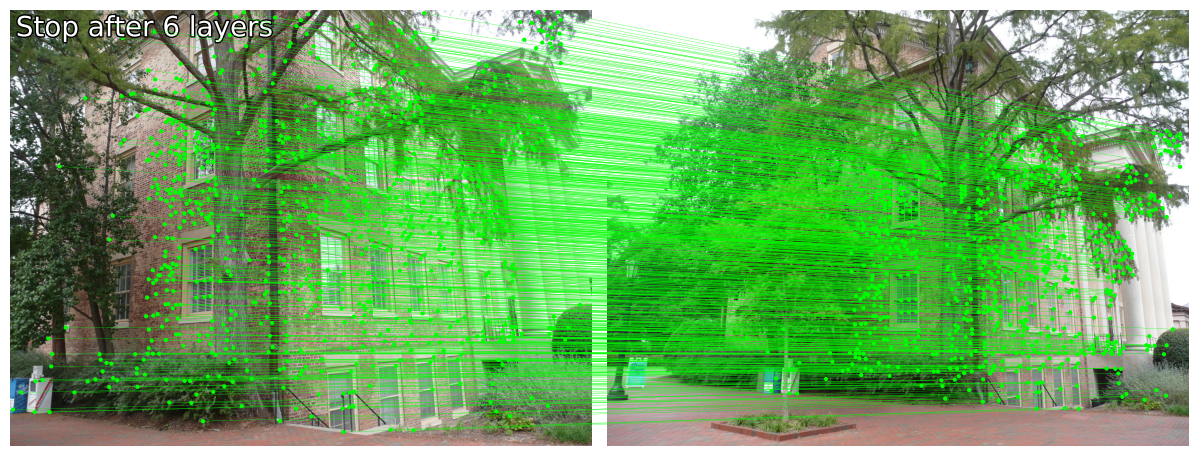

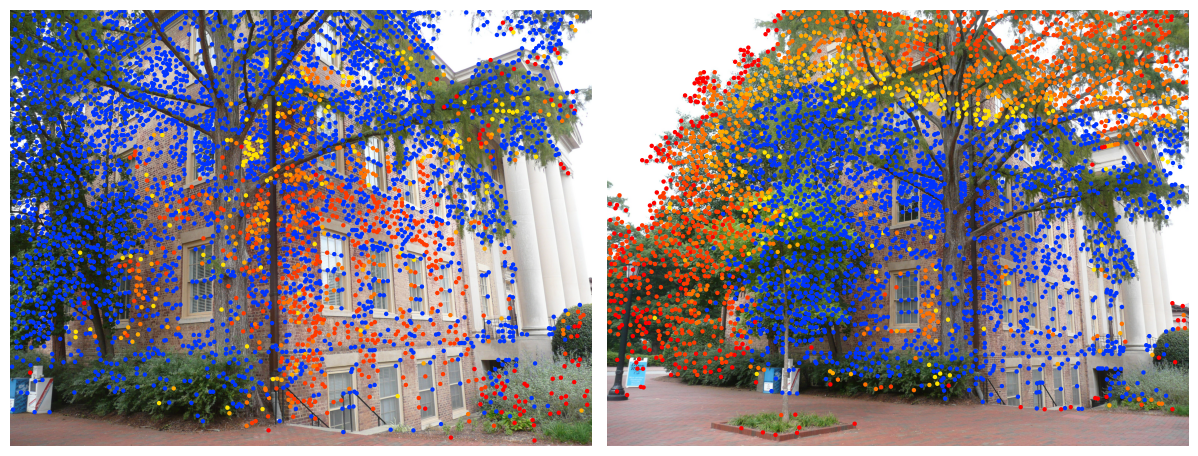

In [ ]:
from lightglue.utils import load_image, rbd
from lightglue import viz2d

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([Image1, Image2])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([Image1, Image2])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

### 画像のペアを取得します。

In [ ]:
def embed_images(
    paths: list[Path],
    model_name: str,
    device: torch.device = torch.device("cpu"),
) :
    """Computes image embeddings.

    Returns a tensor of shape [len(filenames), output_dim]
    """
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).eval().to(device)

    embeddings = []

    for i, path in tqdm(enumerate(paths), desc="Global descriptors"):
        image = load_image(path)

        with torch.inference_mode():
            inputs = processor(images=image, return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs) # last_hidden_state and pooled

            # Max pooling over all the hidden states but the first (starting token)
            # To obtain a tensor of shape [1, output_dim]
            # We normalize so that distances are computed in a better fashion later
            embedding = F.normalize(outputs.last_hidden_state[:,1:].max(dim=1)[0], dim=-1, p=2)

        embeddings.append(embedding.detach().cpu())
    return torch.cat(embeddings, dim=0)

In [ ]:
def get_global_desc(fnames, device = torch.device('cpu')):
    processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
    model = AutoModel.from_pretrained("facebook/dinov2-base")
    model = model.eval()
    model = model.to(device)
    global_descs_dinov2 = []
    for i, img_fname_full in tqdm(enumerate(fnames),total= len(fnames)):
        key = os.path.splitext(os.path.basename(img_fname_full))[0]
        timg = load_image(img_fname_full)
        with torch.inference_mode():
            inputs = processor(images=timg, return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs)
            dino_mac = F.normalize(outputs.last_hidden_state[:,1:].max(dim=1)[0], dim=1, p=2)
        global_descs_dinov2.append(dino_mac.detach().cpu())
    global_descs_dinov2 = torch.cat(global_descs_dinov2, dim=0)
    return global_descs_dinov2

In [ ]:
def get_img_pairs_exhaustive(img_fnames):
    index_pairs = []
    for i in range(len(img_fnames)):
        for j in range(i+1, len(img_fnames)):
            index_pairs.append((i,j))
    return index_pairs

In [ ]:
def get_image_pairs_shortlist(fnames,
                              sim_th = 0.8, # should be strict
                              min_pairs = 20,
                              exhaustive_if_less = 15,
                              device=torch.device('cpu')):
    num_imgs = len(fnames)
    if num_imgs <= exhaustive_if_less:
        return get_img_pairs_exhaustive(fnames)
    descs = get_global_desc(fnames, device=device)
    dm = torch.cdist(descs, descs, p=2).detach().cpu().numpy()


    # removing half
    mask = dm <= sim_th
    total = 0
    matching_list = []
    ar = np.arange(num_imgs)
    already_there_set = []
    for st_idx in range(num_imgs-1):
        mask_idx = mask[st_idx]
        to_match = ar[mask_idx]
        if len(to_match) < min_pairs:
            to_match = np.argsort(dm[st_idx])[:min_pairs]
        for idx in to_match:
            if st_idx == idx:
                continue
            if dm[st_idx, idx] < 200:
                matching_list.append(tuple(sorted((st_idx, idx.item()))))
                total+=1
    matching_list = sorted(list(set(matching_list)))
    return matching_list

In [ ]:
if DEBUG:
  image_list = list(Path(IMAGE_PATH).glob('*.JPG'))[::5]
  print(image_list)
  pairs = get_image_pairs_shortlist(image_list)
  print(pairs)
  print(len(pairs))

[PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180145.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180144.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180154.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180143.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180155.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180153.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180170.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180186.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180180.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180194.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180198.JPG'), PosixPath('/content/drive/MyDrive/dataset/south-building/images/P1180169.JPG'), PosixPath('/content/drive/MyDrive/datas

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

100%|██████████| 16/16 [00:54<00:00,  3.41s/it]

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (11, 12), (11, 13), (11, 14), (11, 15), (12, 13),

In [ ]:
def detect_keypoints(paths, feature_dir=OUT_PATH):
  feature_dir_path = Path(feature_dir)
  with h5py.File(f'{feature_dir}/keypoints.h5', mode="w") as f_keypoints, h5py.File(f'{feature_dir}/descriptors.h5', mode="w") as f_descriptors:
    for path in tqdm(paths, desc='computing keypoints....'):
      key = path.name

      with torch.inference_mode():
        image = load_image(path).to(device)
        feats = EXTRACTOR.extract(image)

      f_keypoints[key] = feats["keypoints"].cpu().numpy()
      f_descriptors[key] = feats["descriptors"].cpu().numpy()

  print('computing finished!!')

In [ ]:
if DEBUG:
  detect_keypoints(image_list)

computing keypoints....: 100%|██████████| 16/16 [01:51<00:00,  6.94s/it]

computing finished!!


In [ ]:
def keypoint_distances(
    paths: list[Path],
    index_pairs: list[tuple[int, int]],
    feature_dir: Path,
    min_matches: int = 15,
    verbose: bool = True,
    device: torch.device = torch.device("cpu"),
):

    matcher = KF.LightGlueMatcher("aliked").eval().to(device)

    with h5py.File(f'{OUT_PATH}/keypoints.h5', mode="r") as f_keypoints,h5py.File(f'{OUT_PATH}/descriptors.h5', mode="r") as f_descriptors,h5py.File(f'{OUT_PATH}/matches.h5', mode="w") as f_matches:

      for idx1, idx2 in tqdm(index_pairs, desc="Computing keypoing distances"):
                key1, key2 = paths[idx1].name, paths[idx2].name

                keypoints1 = torch.from_numpy(f_keypoints[key1][...]).to(device).squeeze(0)
                keypoints2 = torch.from_numpy(f_keypoints[key2][...]).to(device).squeeze(0)


                descriptors1 = torch.from_numpy(f_descriptors[key1][...]).to(device).squeeze(0)
                descriptors2 = torch.from_numpy(f_descriptors[key2][...]).to(device).squeeze(0)

                with torch.inference_mode():
                    distances, indices = matcher(
                        descriptors1,
                        descriptors2,
                        KF.laf_from_center_scale_ori(keypoints1[None]),
                        KF.laf_from_center_scale_ori(keypoints2[None]),
                    )


                # We have matches to consider
                n_matches = len(indices)
                if n_matches:
                    if verbose:
                        print(f"{key1}-{key2}: {n_matches} matches")
                    # Store the matches in the group of one image
                    if n_matches >= min_matches:
                        group  = f_matches.require_group(key1)
                        group.create_dataset(key2, data=indices.detach().cpu().numpy().reshape(-1, 2))

In [ ]:
if DEBUG:
    keypoint_distances(image_list, pairs, OUT_PATH, verbose=False)

Loaded LightGlue model


Computing keypoing distances: 100%|██████████| 120/120 [42:24<00:00, 21.21s/it]


In [ ]:
if DEBUG:
  with h5py.File(f'{OUT_PATH}/keypoints.h5', mode="r") as f_keypoints, h5py.File(f'{OUT_PATH}/descriptors.h5', mode="r") as f_descriptors:
            matcher_params = {
        "width_confidence": -1,
        "depth_confidence": -1,
        "mp": True if 'cuda' in str(device) else False,
    }
            matcher = KF.LightGlueMatcher("aliked", matcher_params).eval().to(device)
            idx1, idx2 = pairs[0]
            key1, key2 = image_list[idx1].name, image_list[idx2].name

            keypoints1 = torch.from_numpy(f_keypoints[key1][...]).to(device).squeeze(0)
            keypoints2 = torch.from_numpy(f_keypoints[key2][...]).to(device).squeeze(0)
            print("Keypoints:", keypoints1.shape, keypoints2.shape)

            descriptors1 = torch.from_numpy(f_descriptors[key1][...]).to(device).squeeze(0)
            descriptors2 = torch.from_numpy(f_descriptors[key2][...]).to(device).squeeze(0)
            print("Descriptors:", descriptors1.shape, descriptors2.shape)

            with torch.inference_mode():
                distances, indices = matcher(
                    descriptors1,
                    descriptors2,
                    KF.laf_from_center_scale_ori(keypoints1[None]),
                    KF.laf_from_center_scale_ori(keypoints2[None]),
                )

  print(distances, indices)

Loaded LightGlue model
Keypoints: torch.Size([4096, 2]) torch.Size([4096, 2])
Descriptors: torch.Size([4096, 128]) torch.Size([4096, 128])
tensor([[0.1765],
        [0.4531],
        [0.3565],
        ...,
        [0.3618],
        [0.6339],
        [0.9881]]) tensor([[   1,   69],
        [   3, 2649],
        [   7,  430],
        ...,
        [4091, 2625],
        [4093, 2026],
        [4095, 3542]])


In [ ]:
len(distances)

1557

In [ ]:
def import_into_colmap(path = IMAGE_PATH ,feature_dit = OUT_PATH , detabase_path = f'{OUT_PATH}/colmap.db'):
  db = COLMAPDatabase.connect(detabase_path)
  db.create_tables()
  single_camera = False
  fname_to_id = add_keypoints(db ,OUT_PATH,IMAGE_PATH ,'','simple-pinhole',single_camera)
  add_matches(db ,OUT_PATH , fname_to_id)
  db.commit()
  db.close()


In [ ]:
import os, argparse, h5py, warnings


if DEBUG:
  import_into_colmap()

    # This does RANSAC
  pycolmap.match_exhaustive(f'{OUT_PATH}/colmap.db')

100%|██████████| 16/16 [00:00<00:00, 123.00it/s]
120it [00:00, 2145.49it/s]             


In [ ]:
if DEBUG:
    mapper_options = pycolmap.IncrementalPipelineOptions()
    mapper_options.min_model_size = 3
    mapper_options.max_num_models = 2

    maps = pycolmap.incremental_mapping(
        database_path=f'{OUT_PATH}/colmap.db',
        image_path=IMAGE_PATH,
        output_path=OUT_PATH,
        options=mapper_options,
    )

In [ ]:
if DEBUG:
    print(maps[0].summary())
    for k, im in maps[0].images.items():
        print("Rotation", im.cam_from_world.rotation.matrix(), "Translation:", im.cam_from_world.translation, sep="\n")
        print()

Reconstruction:
	num_cameras = 13
	num_images = 13
	num_reg_images = 13
	num_points3D = 5580
	num_observations = 13167
	mean_track_length = 2.35968
	mean_observations_per_image = 1012.85
	mean_reprojection_error = 0.694232
Rotation
[[ 0.96382927  0.06515233 -0.25843435]
 [-0.01645175  0.98235535  0.18629899]
 [ 0.26601217 -0.17530872  0.94789471]]
Translation:
[ 0.27301665  0.17645819 -0.23615606]

Rotation
[[ 0.98199153  0.04390336 -0.18375288]
 [-0.01324887  0.98623241  0.16483355]
 [ 0.18845979 -0.15943063  0.96905355]]
Translation:
[-0.22060792 -0.06858418  0.06425699]

Rotation
[[ 0.98371182  0.05007611 -0.17263674]
 [-0.02643694  0.99027305  0.136603  ]
 [ 0.17779806 -0.129814    0.97546716]]
Translation:
[-0.81915667 -0.1060066  -0.1235861 ]

Rotation
[[ 0.98571551  0.02166899  0.16701915]
 [-0.03245386  0.99754115  0.06211603]
 [-0.16526248 -0.06664915  0.98399502]]
Translation:
[-1.3210742   0.29360964  0.01253398]

Rotation
[[ 0.99531831  0.01871797  0.0948214 ]
 [-0.03167741

In [ ]:
result = pycolmap.Reconstruction(f'{OUT_PATH}/0')
result

Reconstruction(num_cameras=13, num_images=13, num_reg_images=13, num_points3D=5580)

In [ ]:
result.export_PLY(f'{OUT_PATH}/0/rec.ply')

In [ ]:
!pip install trimesh scipy pyglet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.2/711.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 42.4 MB/s eta 0:00:00


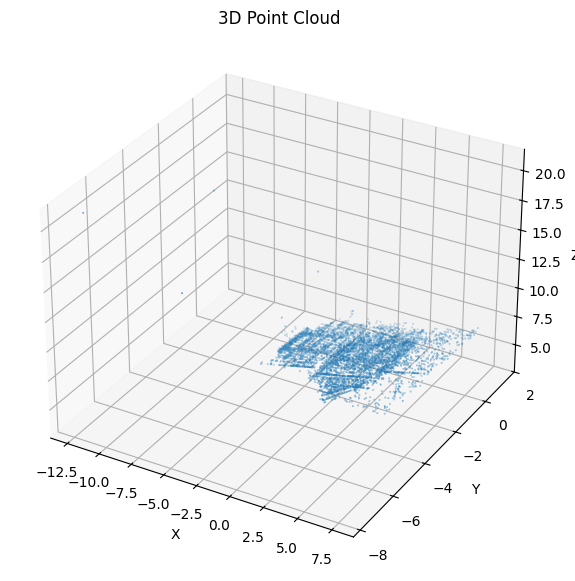

In [ ]:
import trimesh
import matplotlib.pyplot as plt

# PLYファイルのパスを指定
file_path = f'{OUT_PATH}/0/rec.ply'  # PLYファイルのパスを指定

# 点群データの読み込み
point_cloud = trimesh.load(file_path)

# 点群データの表示
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# 点群の座標を抽出してプロット
ax.scatter(point_cloud.vertices[:, 0],
           point_cloud.vertices[:, 1],
           point_cloud.vertices[:, 2],
           s=0.1)  # s=0.1 で点の大きさを設定

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud')

plt.show()

In [ ]:
import plotly.graph_objects as go
import trimesh

# PLYファイルのパスを指定
file_path = f'{OUT_PATH}/0/rec.ply'

# 点群データを読み込みます
try:
    point_cloud = trimesh.load(file_path)

    # 点群の座標と色を取得します
    points = point_cloud.vertices
    # colors = point_cloud.colors  # 元の色は使用しない

    # Plotlyの3D散布図を作成します
    fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=1,  # 点のサイズを調整できます
            color='blue',  # 点の色を赤に変更
            # colorscale='Viridis',  # カラーマップは不要
            opacity=0.8
        )
    )])

    # レイアウトを設定します
    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=400,  # 図の幅を小さくする例
        height=400  # 図の高さを小さくする例
    )

    # プロットを表示します
    fig.show()

except FileNotFoundError:
    print(f"エラー: ファイル '{file_path}' が見つかりません。")
except Exception as e:
    print(f"エラーが発生しました: {e}")